In [ ]:
num_multiple_features = 20
num_multiple_latents = 8
expansion_factor = 4

In [1]:
import torch
import math
import random
import matplotlib.pyplot as plt
from utils.embeddings import sample_circle_features

from utils.embeddings import sample_embeddings
# seed math and torch
torch.manual_seed(0)
random.seed(0)

linear_feature_embeddings = torch.tensor(
    [
        [0., 0, 0, 1.],
        [0., 0, 1, 0.],
        [0., 0, -1, -10.],
        # [1., 0, 1, 0.],
        # [-1, 0, -1, 1]
    ]
)

num_linear_features = linear_feature_embeddings.shape[0]

linear_feature_embeddings /= torch.norm(linear_feature_embeddings, dim=1, keepdim=True)

multi_dim_feature_embeddings = sample_circle_features(num_multiple_features, bias=torch.tensor([0.5, 0.5]), random=False)

# make multi_dim_feature_embeddings 4D by concatenating zeros 2 times
zeros = torch.zeros(multi_dim_feature_embeddings.shape[0], 2)
multi_dim_feature_embeddings = torch.cat([multi_dim_feature_embeddings, zeros], dim=1)

In [2]:
sample = True
dont_add_both = True
if sample:
    linear_feature_freqs = torch.ones(linear_feature_embeddings.shape[0])
    linear_feature_freqs /= linear_feature_freqs.sum(dim=0) 

    multi_dim_feature_freqs = torch.ones(multi_dim_feature_embeddings.shape[0])
    multi_dim_feature_freqs /= multi_dim_feature_freqs.sum(dim=0) 

    linear_exists_prob = 0.5
    multi_dim_exists_prob = 0.9

    embeddings_dataset = [sample_embeddings(linear_feature_embeddings, multi_dim_feature_embeddings, linear_feature_freqs, multi_dim_feature_freqs, linear_exists_prob, multi_dim_exists_prob, dont_add_both=dont_add_both) for _ in range(100)]

    # make a dataset out of it
    labels = [d["label"] for d in embeddings_dataset]
    dataset = torch.stack([d["x"] for d in embeddings_dataset])
else:
    dataset = torch.cat([linear_feature_embeddings, multi_dim_feature_embeddings], dim=0)
    linear_labels = torch.cat([torch.eye(linear_feature_embeddings.shape[0]), torch.zeros(multi_dim_feature_embeddings.shape[0], linear_feature_embeddings.shape[0])], dim=0)
    multi_dim_labels = torch.cat([torch.zeros(linear_feature_embeddings.shape[0], multi_dim_feature_embeddings.shape[0]), torch.eye(multi_dim_feature_embeddings.shape[0])], dim=0)
    labels = [(l, m) for l, m in zip(linear_labels, multi_dim_labels)]

# print(labels)

In [3]:
from sae.sae import SAE
from sae.sae_config import SAEConfig, MultiDimSAEConfig
from sae.multi_dim_sae import MultiDimSAE
import torch.nn.functional as F


m_config = SAEConfig(
    input_dim=4,
    latent_dim=num_linear_features*expansion_factor,
    l1_weight=0.1,
    activation_fn=F.relu,
    learning_rate=0.001,
    multi_dim_config=MultiDimSAEConfig(num_multi_dim_features=num_multiple_features),
)
m_sae = MultiDimSAE(m_config).train_model(dataset=dataset, num_epochs=5000)

100%|██████████| 5000/5000 [00:04<00:00, 1033.02it/s]


In [4]:
m_sae.plot_losses()

In [5]:
concatenated_labels = torch.stack([torch.cat(label) for label in labels])
label_l0 = (concatenated_labels > 0).float().sum(dim=1).mean().item()

label_l0

1.309999942779541

### Compare reconstruction of features

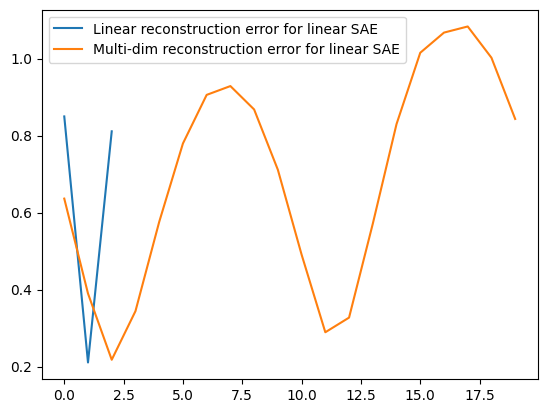

In [6]:
from utils.eval import compute_similarities

l_linear_similarities, l_multi_similarities = compute_similarities(m_sae, linear_feature_embeddings, multi_dim_feature_embeddings, use_linear_SAE=True)

plt.plot(l_linear_similarities, label="Linear reconstruction error for linear SAE")
plt.plot(l_multi_similarities, label="Multi-dim reconstruction error for linear SAE")
plt.legend()
plt.show()

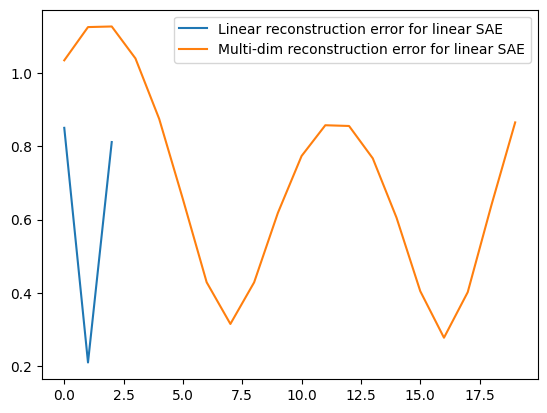

In [7]:
m_linear_similarities, m_multi_similarities = compute_similarities(m_sae, linear_feature_embeddings, multi_dim_feature_embeddings, use_linear_SAE=False)

plt.plot(l_linear_similarities, label="Linear reconstruction error for linear SAE")
plt.plot(m_multi_similarities, label="Multi-dim reconstruction error for linear SAE")
plt.legend()
plt.show()


### Latent activation on features

In [8]:
from utils.plotter import plot_latent_activations

# Plot linear latents
plot_latent_activations(
    m_sae, linear_feature_embeddings, multi_dim_feature_embeddings, use_linear=True
)

In [9]:
plot_latent_activations(m_sae, linear_feature_embeddings, multi_dim_feature_embeddings, use_linear=False)